In [1]:
from functions import *

# Analyse rotations

## Extract frames from video

In [9]:
vidcap = cv2.VideoCapture('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05.mp4')
# vidcap = cv2.VideoCapture('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/DSC_6429.MP4')
success,image = vidcap.read()
count = 0
while success :
  cv2.imwrite(f'/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/frame{count:04}.png', image)     # save frame as png file      
  # cv2.imwrite(f'/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/calibration.png', image)     # save frame as png file      
  success,image = vidcap.read()
  print('Read a new frame: ', success,count)
  count += 1

Read a new frame:  True 0
Read a new frame:  True 1


KeyboardInterrupt: 

## Calibration

In [3]:
area_px = 1694812 # done with fiji
area_m = np.pi*0.0405**2
calibration = np.sqrt(area_px/area_m) #px/m
print(calibration)

18135.553113664875


## Plot full contour

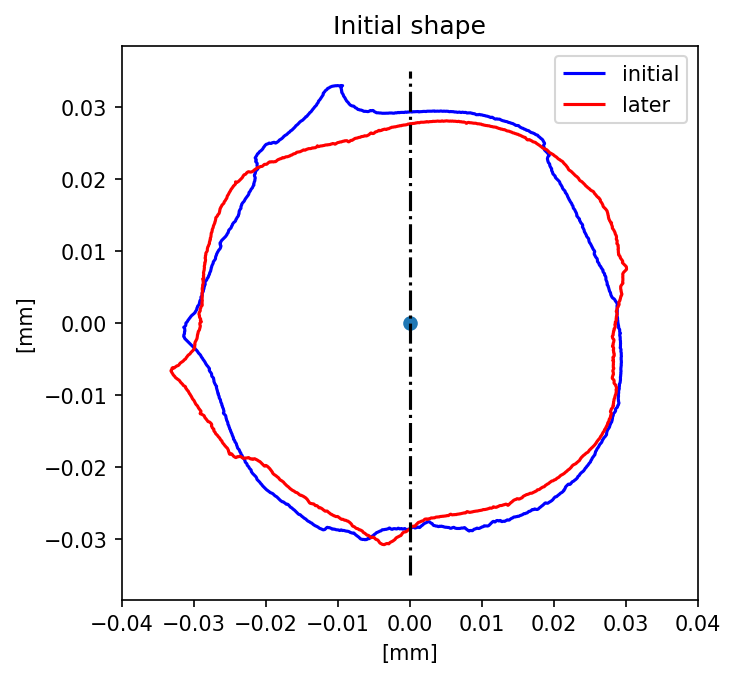

In [ ]:
initial = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/full_contours/0051.csv'
later = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/full_contours/0115.csv'

contour = np.genfromtxt(initial,dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
contour = contour/calibration
com,_ = hydrostasy(contour)
# contour = rotate(contour,[com.x,com.y],180)
contour[:,0] = (contour[:,0] - com.x)
contour[:,1] = -(contour[:,1] - com.y)
_,cob = hydrostasy(contour)
initial = Polygon(contour)

contour = np.genfromtxt(later,dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
contour = contour/calibration
com,_ = hydrostasy(contour)
# contour = rotate(contour,[com.x,com.y],180)
contour[:,0] = (contour[:,0] - com.x)
contour[:,1] = -(contour[:,1] - com.y)
_,cob = hydrostasy(contour)
later = Polygon(contour)

fig,ax = plt.subplots(dpi=150)
gpd.GeoSeries([initial]).boundary.plot(ax=ax,colors='blue',label='initial')
gpd.GeoSeries([later]).boundary.plot(ax=ax,colors='red',label='later')

ax.scatter(0,0,marker='o',color='tab:blue')
ax.vlines(0,-0.035,0.035,colors='k',linestyles='-.')
ax.set_aspect('equal')
plt.legend()
ax.set_xlim(-0.04,0.04)
ax.set_ylabel('[mm]')
ax.set_xlabel('[mm]')
ax.set_title('Initial shape')
plt.show()


## Calculate moment of inertia

The idea is that the discrepancy in the calculations could come from the fact that I calculated the moment of inertia assuming that my shape is a disk, where in fact is not.

In [ ]:
from section import summary, outline
# https://en.wikipedia.org/wiki/Perpendicular_axis_theorem 
shape = list(zip(contour[:,0], contour[:,1]))
print(summary(shape))
# outline(shape, 'skewed', format='png', size=(8, 6))
print(f'moment of inertia from shape ={917*(59872821050.65208+69880879439.41838)/calibration**4:.4e}') # the area of a pixel is calibration**2
print(f'moment of inertia from radius = {.0295**2*.5*np.pi*.0295**2*917:.4e}')
print(f'ratio moments of inertia = {(17*(59872821050.65208+69880879439.41838)/calibration**4) / (.0295**2*.5*np.pi*.0295**2*917) :.4e}')

Area
  A = -898870.6924500022
Centroid
  cx = 2.8209197896987914e-12
  cy = 1.351337270360277e-12
Moments and product of inertia
  Ixx = -59872821050.65208
  Iyy = -69880879439.41838
  Ixy = 2216732507.176184
Principal moments of inertia and direction
  I1 = -59403806193.81378
  I2 = -70349894296.25668
  θ︎ = -11.946420399743337°
moment of inertia from shape =1.0999e-03
moment of inertia from radius = 1.0909e-03
ratio moments of inertia = 1.8693e-02


## Plot motion

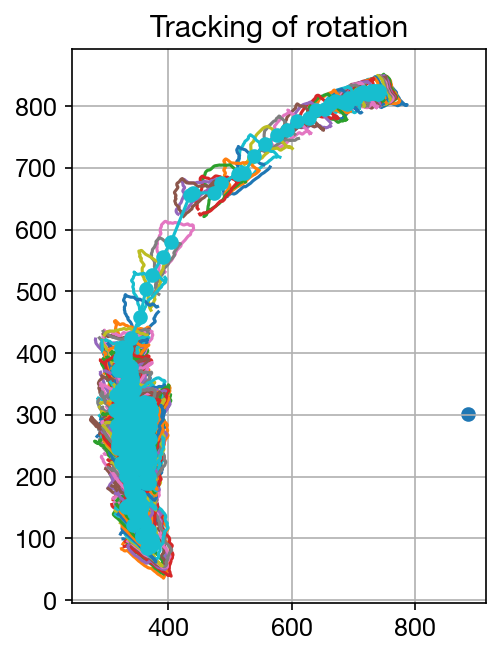

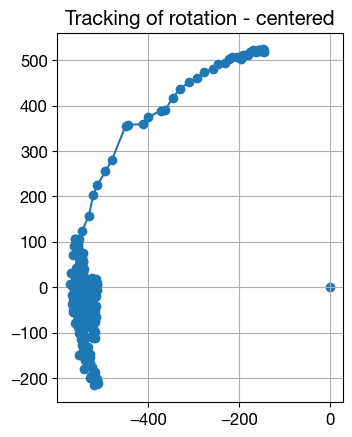

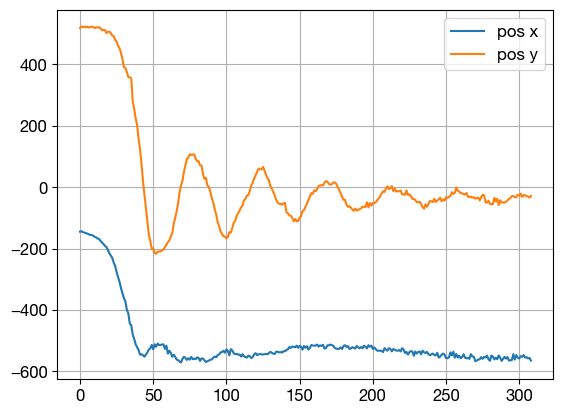

In [8]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/contours/'

plt.figure(dpi=150)

contoursPATH = []
for contour in glob.glob(directory+'/*.csv'):
    contoursPATH.append(contour)
contoursPATH = np.sort(contoursPATH)

pos_x = []
pos_y = []
for it,contourPATH in enumerate(contoursPATH[::]):
    contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
    if contour.shape[1]!=2: contour = contour.T
    contour[:,1] = contour[:,1]*-1 +1000
    plt.plot(contour[:,0],contour[:,1])
    com,_ = hydrostasy(contour)
    pos_x.append(com.x)
    pos_y.append(com.y)
xc, yc, r, _ = circle_fit.taubinSVD(np.vstack((pos_x,pos_y)).T)
plt.scatter(xc,yc)

plt.plot(pos_x,pos_y,marker='o')
plt.title('Tracking of rotation')
plt.grid()
plt.gca().set_aspect('equal')
# plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')
plt.show()

pos_x = pos_x-xc
pos_y = pos_y-yc

plt.figure()
plt.scatter(0,0)
plt.plot(pos_x,pos_y,marker='o')
plt.title('Tracking of rotation - centered')
plt.grid()
plt.gca().set_aspect('equal')
# plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')
plt.show()

plt.figure()
plt.plot(pos_x,label='pos x')
plt.plot(pos_y,label='pos y')
plt.grid()
plt.legend()
plt.show()

## Analytic fit

radius is 0.0299 m
100 139
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 214
    # variables        = 3
    chi-square         = 0.32500492
    reduced chi-square = 0.00154031
    Akaike info crit   = -1382.83667
    Bayesian info crit = -1372.73874
[[Variables]]
    alpha:   18689.3463 +/- 142.290659 (0.76%) (init = 21984.13)
    C_d:     0.41351666 +/- 0.01376405 (3.33%) (init = 0.5)
    theta0:  0 (fixed)
    omega0:  1.50814412 +/- 0.05626232 (3.73%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, C_d)    = -0.7592
    C(alpha, omega0) = -0.7460
    C(C_d, omega0)   = +0.6296


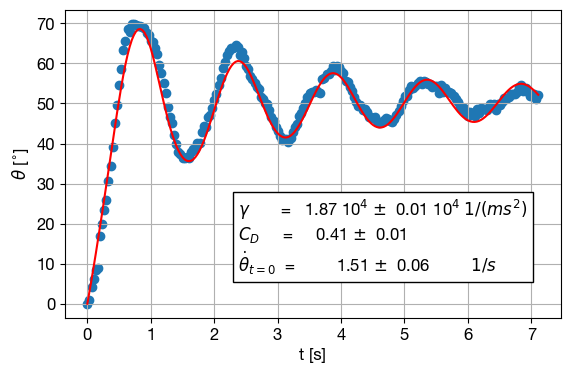

In [10]:
itry = 30
# load contour 
frame = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/full_contours/0051.csv'
contour = np.genfromtxt(frame,dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
contour = contour/calibration
com,_ = hydrostasy(contour)
contour[:,0] = (contour[:,0] - com.x)
contour[:,1] = -(contour[:,1] - com.y)
_,cob = hydrostasy(contour)
straight = Polygon(contour)
# find radius
print(f'radius is {np.sqrt(straight.area/np.pi):.4f} m')
radius_rot = np.sqrt(straight.area/np.pi) # in meters, radius for rotations
# calculate stabilty
angleStep = 0.5
stability = np.zeros((int(360/angleStep),2))
for i,angle in enumerate(np.arange(0,360,angleStep)):
    com,_ = hydrostasy(contour) ### CHANGE SALTY OR FRESH
    rotatedCont = rotate(contour,[com.x,com.y],-angle)
    del com
    com,cob = hydrostasy(rotatedCont)  ### CHANGE SALTY OR FRESH
    stability[i] = angle, com.x-cob.x
# prepare experimental data
theta_eq = np.where(np.arctan2(pos_y,pos_x)<0,np.arctan2(pos_y,pos_x)+2*np.pi,np.arctan2(pos_y,pos_x))[-1] #last point of raw data
theta_exp = np.arctan2(pos_y,pos_x)[itry:-65]
theta_exp = np.where(theta_exp<0,theta_exp+2*np.pi,theta_exp)
time = 1/29.97*np.arange(len(pos_x))
t = time[itry:-65]
theta_0 = theta_exp[0]
# shift stability array
index1 = np.where(stability[:,0]==find_nearest(stability[:,0],np.rad2deg(theta_eq-theta_0)))[0][0]
zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
index2 = zero_crossings[0]
print(index1,index2)
stability[:,1] = np.roll(stability[:,1],axis=0,shift=int(index1-index2))
a_vec = stability[:,1] # in m
# plt.plot(np.linspace(0,2*np.pi,len(a_vec)),a_vec)
# plt.grid()
# plt.ylabel('CoM-CoB [m]')
# plt.xlabel('angle [rad]')
# plt.vlines(np.mean(theta_eq-theta_0),-0.0002,0.00035)
# plt.show()


theta_exp -= theta_exp[0]

# ic params
alpha= 2*9.81/radius_rot**2
C_d=.5
theta0 = 0.
omega0 = .5

#functions definitions
def motion(y,t,paras):
    theta, omega = y
    theta_deg = np.rad2deg(theta)
    closest_known_angle = find_nearest(stability[:,0],theta_deg)
    index = np.where(stability[:,0]==closest_known_angle)[0][0]
    try:
        alpha = paras['alpha'].value
        C_d = paras['C_d'].value
    except KeyError:
        alpha,C_d = paras
    rhoStar = 1000/917
    dydt = [omega, - alpha*a_vec[index] - 2*C_d*rhoStar*omega*np.abs(omega)]
    return dydt

def odesol(t,x0,paras): # x0 are the initial conditions OF THE FUNCTION
    sol = odeint(motion, x0, t, args=(paras,))
    return sol

def residual(paras, t, theta_exp):
    x0 = [paras['theta0'].value,paras['omega0'].value]
    model = odesol(t, x0, paras)
    theta_mod = model[:, 0]
    return (theta_mod - theta_exp).ravel()

# fit model
plt.figure(figsize=(6.4,4))
params = Parameters()
params.add('alpha', value=alpha,vary=True)
params.add('C_d',value=C_d,vary=True)
params.add('theta0',value=theta0,vary=False)
params.add('omega0',value=omega0,vary=True)
result = minimize(residual, params, args=(t, theta_exp))  

# check results of the fit
data_fitted = odesol(t, [result.params["theta0"].value,result.params["omega0"].value], result.params)
plt.plot(t-1,np.rad2deg(data_fitted[:,0]),c='red')

# plot and friends
plt.scatter(t-1,np.rad2deg(theta_exp))
props = dict(boxstyle='square', facecolor='white', alpha=1)
textstr = r'$\gamma$       = ' + f'  {result.params["alpha"].value/1e4:.2f}'+r' 10$^4$'+r' $\pm$ '+f' {unumpy.std_devs(result.uvars["alpha"])/1e4:.2f}'+r' 10$^4$'+r' $1/(ms^2)$'+'\n' +\
            r'$C_D$     = ' + f'   \t{result.params["C_d"].value:0<4.2f}'+r' $\pm$ '+f' {unumpy.std_devs(result.uvars["C_d"]):0<4.2f}\n' +\
            r'$\dot{\theta}_{t=0}$  = ' + f'        {result.params["omega0"].value:0<4.2f}'+r' $\pm$ '+f' {unumpy.std_devs(result.uvars["omega0"]):0<4.2f}        '+r' $1/s$' 
plt.text(0.35,0.15,textstr,transform=plt.gca().transAxes,bbox=props)
plt.xlabel('t [s]')
plt.ylabel(r'$\theta$ [$^{\circ}$]')
plt.grid()
report_fit(result)
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/oscillationsFit.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [3]:
print(f'{Ra(0.029,0,19.6):.2e}')

1.60e+07
